#### Notebook to run experiments in "The Effective Vertical Anisotropy of Layered Aquifers" by Mark Bakker and Bram Bot.

Reference: M. Bakker and B. Bot (2024) The effective vertical anisotropy of layered aquifers. Groundwater. Available online early: [doi](https://doi.org/10.1111/gwat.13432).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

import timml as tml

Function to generate hydraulic conductivities

In [2]:
def generatek(ksection=20 * [0.1, 1], nsections=10, seed=1):
    """Generate k.

    Input:
    ksection: k values in the section
    nsection: number of sections
    seed: seed of random number generator
    """
    nk = len(ksection)
    # nlayers = nk * nsections
    kaq = np.zeros((nsections, nk))
    rng = np.random.default_rng(seed)
    for i in range(nsections):
        kaq[i] = rng.choice(ksection, nk, replace=False)
    return kaq.flatten()

Function to create a model with a canal given `kx` and `kz`. 

In [3]:
def makemodel(kx, kz, d=4, returnmodel=False):
    """Creates model with river at center, and water supplied from infinitiy.

    d is depth of river.
    """
    H = 40  # thickness of model
    # d = 4 # depth of river
    naq = len(kx)
    ml = tml.Model3D(kaq=kx, z=np.linspace(H, 0, naq + 1), kzoverkh=kz / kx)
    tml.LineSink1D(ml, xls=0, sigls=2, layers=np.arange(int(d * 10)))
    tml.Constant(ml, xr=2000, yr=0, hr=0, layer=0)
    ml.solve(silent=True)
    if returnmodel:
        return ml
    return ml.head(0, 0)[0]


def func(kz, kx, h0, d=4, nlayers=400):
    """Computes head difference."""
    hnew = makemodel(kx * np.ones(nlayers), kz * np.ones(nlayers), d, returnmodel=False)
    return hnew - h0

Function to create a model with a partially penetrating well.

In [4]:
def makemodelradial(kx, kz, d=4, rw=0.1, returnmodel=False):
    """Creates model with river at center, and water supplied from infinitiy."""
    H = 40  # thickness of model
    # d = 4 # depth of river
    Qw = 1000
    naq = len(kx)
    ml = tml.Model3D(kaq=kx, z=np.linspace(H, 0, naq + 1), kzoverkh=kz / kx)
    tml.Well(ml, xw=0, yw=0, Qw=Qw, rw=rw, layers=np.arange(int(d * 10)))
    tml.Constant(ml, xr=2000, yr=0, hr=0, layer=0)
    ml.solve(silent=True)
    if returnmodel:
        return ml
    return ml.head(0, 0)[0]


def funcradial(kz, kx, h0, d=4, rw=0.1, nlayers=400):
    """Computes head difference."""
    hnew = makemodelradial(
        kx * np.ones(nlayers), kz * np.ones(nlayers), d, rw, returnmodel=False
    )
    return hnew - h0

Find effective vertical hydraulic conductivity for one realization of 400 layers and time it

In [5]:
kaq = 80 * [1, 3.16, 10, 31.6, 100]  # 400 k values
k = generatek(ksection=kaq, nsections=1)  # random order of k values
h0 = makemodel(k, k)  # head at canal
kx = np.mean(k)  # equivalent horizontal k
# vertical hydraulic conductivity:
%timeit kz = brentq(func, a=0.001 * kx, b=kx, args=(kx, h0)) 

2.6 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Run the experiment for Figure 3a. This is commented out because it takes a long time to run. The number of the realization is printed to the screen every 10 realizations. 

So 1000 realizations takes on the order of 3000 seconds (on this machine), so around 50 minutes. 

In [6]:
kaq = np.array(80 * [1, 3.16, 10, 31.6, 100])
ntot = 1000
aniso = np.zeros(ntot)

for i in range(ntot):
    k = generatek(kaq, nsections=1, seed=i)
    h0 = makemodel(k, k)
    kx = np.mean(k)
    kz = brentq(func, a=0.001 * kx, b=kx, args=(kx, h0))
    aniso[i] = kx / kz
    if i % 10 == 0:
        print(i, end=" ")
print("\n completed")

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 
 completed


Create figure 3a

In [11]:
from scipy.stats import lognorm


def create_fig3a():
    plt.figure(figsize=(3, 3))
    plt.subplot(211)
    plt.hist(aniso, bins=np.arange(2, 20, 0.5), density=True)
    p5, p50, p95 = np.percentile(aniso, [5, 50, 95])
    # print('p5, p50, p95', p5, p50, p95)
    plt.axvline(p5, color="C1")
    plt.axvline(p95, color="C1")
    plt.axvline(p50, color="C2")
    kheq = np.mean(kaq)
    kveq = len(kaq) / np.sum(1 / kaq)
    anisoeq = kheq / kveq
    plt.axvline(anisoeq, color="k", linestyle=":", linewidth=1)
    #
    shape, loc, scale = lognorm.fit(aniso)
    # print('shape, loc, scale: ', shape, loc, scale)
    x = np.linspace(0, 20, 100)
    pdf1 = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, pdf1, "k--", lw=1)
    plt.xlim(0, 20)
    plt.ylim(0, 0.25)
    plt.xticks(np.arange(0, 21, 4))
    plt.xlabel(r"$\alpha_{eff}$ for $d=4$ m")
    plt.ylabel("pdf")
    plt.tight_layout()

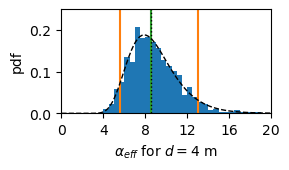

In [12]:
# Only run if anisotropy has been computed
create_fig3a()